In [ ]:
# pip install statsmodels

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# AR - Autoregressive Model

**Auto**_regressive_ := we _regress_ the target variable on **its own past values**

## Warmup: do past values correlate with current value?

### a. Load the data - IMPORTANT: remainder.csv!

In [2]:
df=pd.read_csv('flight_remainder.csv')

In [3]:
# Plot the data
def plot_remainder(df, title='Remaining Passenger Number after modelling Trend and Seasonality'):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    plt.show()

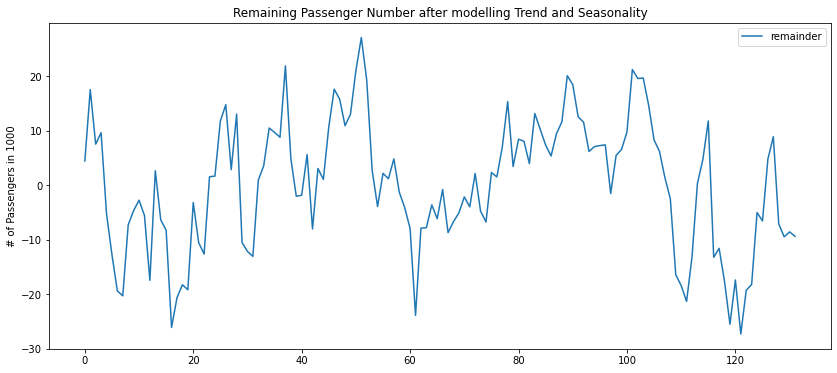

In [4]:
plot_remainder(df[['remainder']])

### b. Create a time-lagged input feature: lag1

**Lag** =: interval of time between to related phenomena. 

The two _related phenomena_ in this case are the remainder today and the remainder tomorrow.

In [5]:
df['lag1'] = df['remainder'].shift(1)
df['lag2'] = df['remainder'].shift(2)
df['lag3'] = df['remainder'].shift(3)

### c. Inspect correlations

<AxesSubplot:xlabel='lag1', ylabel='remainder'>

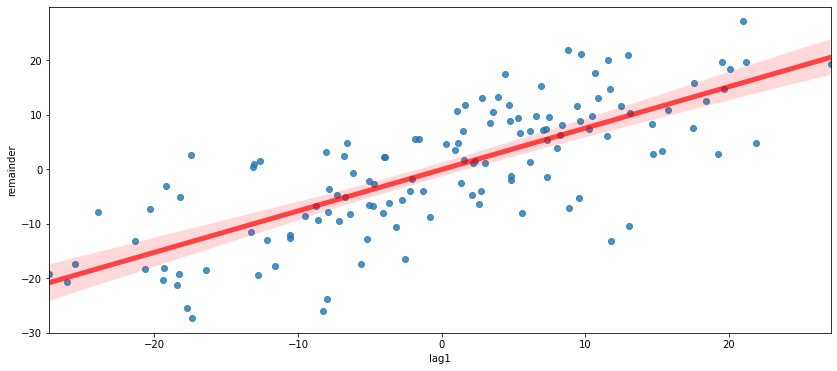

In [6]:
sns.regplot(x = df['lag1'], y= df['remainder'],line_kws={"color":"r","alpha":0.7,"lw":5})

In [7]:
df[['lag1','lag2','lag3','remainder']].corr()

,lag1,lag2,lag3,remainder
lag1,1.000000,0.757158,0.600847,0.758226
lag2,0.757158,1.000000,0.756064,0.602811
lag3,0.600847,0.756064,1.000000,0.394713
remainder,0.758226,0.602811,0.394713,1.000000


---- 

<AxesSubplot:>

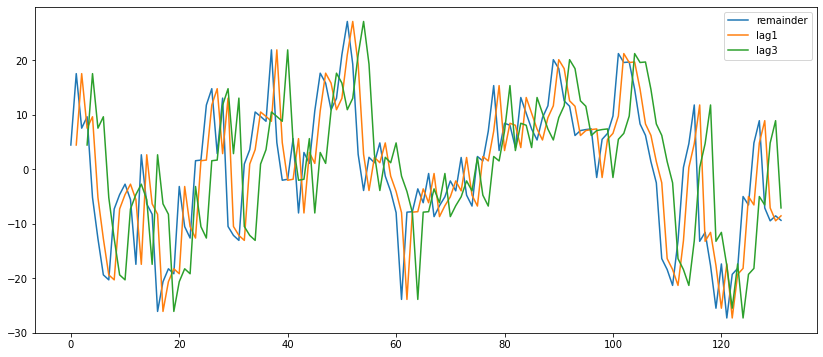

In [8]:
df[['remainder','lag1','lag3']].plot()

# AR - Autoregressive Model

In the autoregressive model we model the future value of a variable by looking at the present (and maybe past) value of the same variable. In our case the variable will be the **remainder**.

$$
y_{t+1} = w_0 + \sum_{j=0}^{P-1}w_{j}y_{t-j} + \epsilon_t
$$

where: 
- $t$ is the current timestep
- $w_0$ is the bias/intercept
- w’s are the weights of the model 
- $\epsilon$ is some **iid** (independent and identically distributed e.g. Gaussian - more on this in the afternoon) noise - **P** is the number of lags to use for the model. It is a hyperparameter that we have to choose.

**AR(1) - Model**

$$
\hat{y_{t+1}} = w_0 + w_1 * y_{t}
$$

or in case of our remainder

$$
\hat{remainder_{t+1}} = w_0 + w_1 * remainder_{t}
$$

In an AR(1) model we model the value in $t+1$ as a linear function of the value in $t$.

**AR(2) - Model**

$$
\hat{y_{t+1}} = w_0 + w_1 * y_{t} + w_2 * y_{t-1}
$$

## 1. Run an Autoregression (Linear Regression) of lag1 on the remainder

In [9]:
# Drop missing values
df.dropna(inplace=True)

In [10]:
# Assign X and y
X = df[['lag1']]
y = df['remainder']

In [11]:
from sklearn.linear_model import LinearRegression
# Create and fit the model
m = LinearRegression()
m.fit(X,y)

LinearRegression()

In [12]:
# Create predictions
df['pred_lag1'] = m.predict(X)
df.head()

,passengers,year,month,timestamp,trend,month__1,month__2,month__3,month__4,month__5,...,month__11,month__12,seasonal,trend_seasonal,remainder,noise,lag1,lag2,lag3,pred_lag1
3,93,1949,4,3,86.397226,0,0,0,1,0,...,0,0,222.818182,83.412879,9.587121,-7.941003,7.496212,17.496212,4.405303,5.555557
4,80,1949,5,4,88.714870,0,0,0,0,1,...,0,0,224.636364,85.231061,-5.231061,10.599310,9.587121,7.496212,17.496212,7.148146
5,103,1949,6,5,91.032514,0,0,0,0,0,...,0,0,255.181818,115.776515,-12.776515,6.546537,-5.231061,9.587121,7.496212,-4.138464
6,122,1949,7,6,93.350159,0,0,0,0,0,...,0,0,280.818182,141.412879,-19.412879,-1.576632,-12.776515,-5.231061,9.587121,-9.885634
7,122,1949,8,7,95.667803,0,0,0,0,0,...,0,0,281.727273,142.321970,-20.321970,-2.198205,-19.412879,-12.776515,-5.231061,-14.940374


<AxesSubplot:>

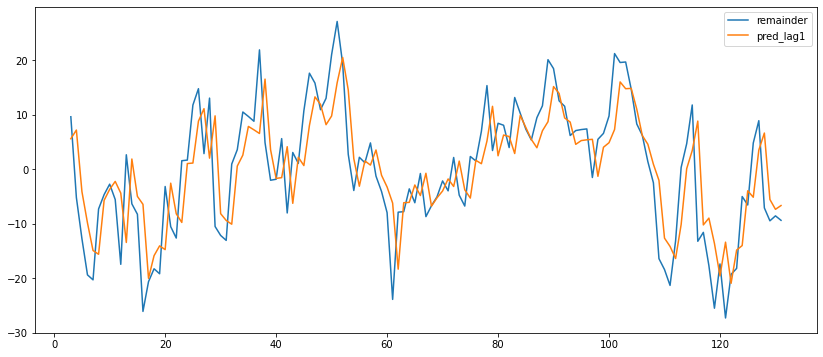

In [13]:
# Plot the original remainder and the prediction
df[['remainder', 'pred_lag1']].plot()

In [14]:
# LEft is only the residuals: what is the residual compared to the remainder?
df['residual'] = df['remainder']-df['pred_lag1']

(<AxesSubplot:>, <AxesSubplot:>)

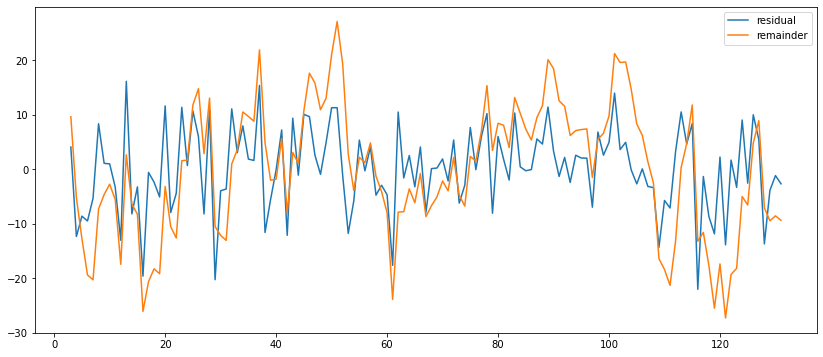

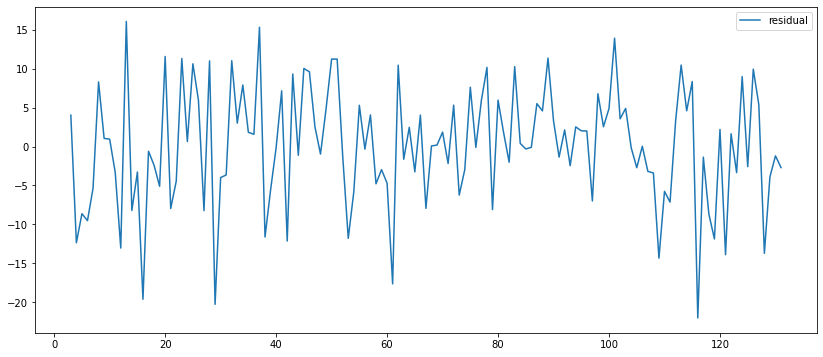

In [15]:
df[['residual','remainder']].plot(), df[['residual']].plot()

## 2. Determining P: number of lags to use 

In [16]:
# example lag2
df[['lag1','lag2','remainder']].corr()

,lag1,lag2,remainder
lag1,1.000000,0.759824,0.761109
lag2,0.759824,1.000000,0.602287
remainder,0.761109,0.602287,1.000000


### 2.1 Partial Autocorrelation analysis

Plot the Partial Autocorrelation between different lags. 

$$
\delta_h = Corr(y_t, y_{t-h}|y_{t-1}, ..., y_{t-h+1})
$$

PACF is the correlation between $y_t$ and $y_{t−h}$, conditional on the intermediate values (eg. $y_{t-1}$, $y_{t-2}$, ...). 

They are basically nothing else than the coefficients in a linear regression if you included h lags.

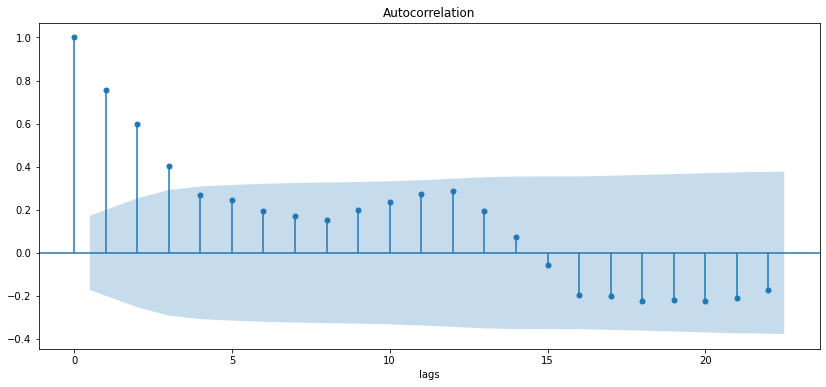

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['remainder'])
plt.xlabel('lags');

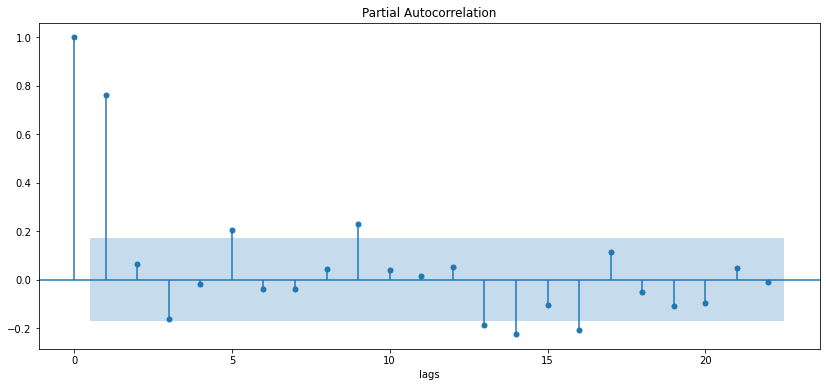

In [18]:
# Statsmodels provides a function called plot_pacf
# plot partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['remainder'])
plt.xlabel('lags');

**Box-Jenkins-Methodology:**

This methodology makes a statement about how to choose lags.

We will choose all lags until the first sharp drop in values. In this case we will have 1 lag. This is the point after which we know the correlation dropped significantly. 

### 2.2 Statsmodels `ar_select_order`

In [39]:
selected_order = ar_select_order(df['remainder'], maxlag = 12)

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_

In [40]:
selected_order.ar_lags

array([1])

### Bonus Statsmodels `AutoReg`

Statsmodels also has an AutoReg which does a bit of the modelling for you.

In [41]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(endog=df['remainder'], lags=1).fit()

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [42]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                  129
Model:                     AutoReg(1)   Log Likelihood                -442.870
Method:               Conditional MLE   S.D. of innovations              7.698
Date:                Thu, 29 Apr 2021   AIC                              4.129
Time:                        21:01:03   BIC                              4.196
Sample:                             1   HQIC                             4.156
                                  129                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.1859      0.680     -0.273      0.785      -1.520       1.148
remainder.L1     0.7600      0.057     13.239      0.000       0.647       0.872
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3159           +0.0000j            1.3159            0.0000
-----------------------------------------------------------------------------
"""

# What now?

In [43]:
ar_model.predict()

3      -9.895481
4     -14.938837
5     -15.629707
6      -5.750258
7      -3.746733
         ...    
127    -7.402590
128    -6.711719
129          NaN
130          NaN
131          NaN
Length: 129, dtype: float64

- This morning we completely focused on modelling the remainder separate from everything else.
- In the end we are still interested in the absolute number of passengers (or temperature), not in the remainder itself.

Next step: Add the lag of the remainder as a feature to your DataFrame and create a new model with the features timestep, seasonal_dummies, lag1 of the remainder

In [44]:
df['ar_predict']=ar_model.predict()

<AxesSubplot:>

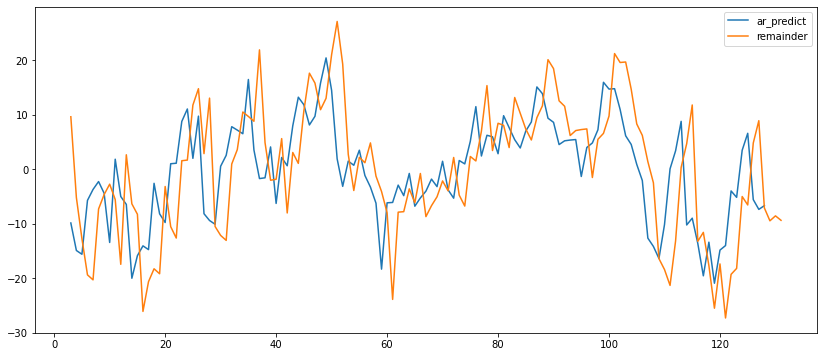

In [45]:
df[['ar_predict','remainder']].plot()

In [46]:
df['total_predict']=df['ar_predict']+df['trend_seasonal']

<AxesSubplot:>

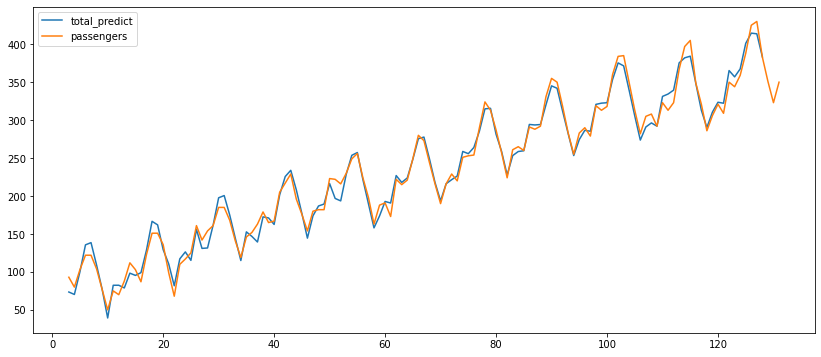

In [47]:
df[['total_predict','passengers']].plot()

In [48]:
df.head(5)

,passengers,year,month,timestamp,trend,month__1,month__2,month__3,month__4,month__5,...,trend_seasonal,remainder,noise,lag1,lag2,lag3,pred_lag1,residual,ar_predict,total_predict
3,93,1949,4,3,86.397226,0,0,0,1,0,...,83.412879,9.587121,-7.941003,7.496212,17.496212,4.405303,5.555557,4.031564,-9.895481,73.517397
4,80,1949,5,4,88.714870,0,0,0,0,1,...,85.231061,-5.231061,10.599310,9.587121,7.496212,17.496212,7.148146,-12.379207,-14.938837,70.292224
5,103,1949,6,5,91.032514,0,0,0,0,0,...,115.776515,-12.776515,6.546537,-5.231061,9.587121,7.496212,-4.138464,-8.638051,-15.629707,100.146808
6,122,1949,7,6,93.350159,0,0,0,0,0,...,141.412879,-19.412879,-1.576632,-12.776515,-5.231061,9.587121,-9.885634,-9.527244,-5.750258,135.662621
7,122,1949,8,7,95.667803,0,0,0,0,0,...,142.321970,-20.321970,-2.198205,-19.412879,-12.776515,-5.231061,-14.940374,-5.381595,-3.746733,138.575237


<AxesSubplot:>

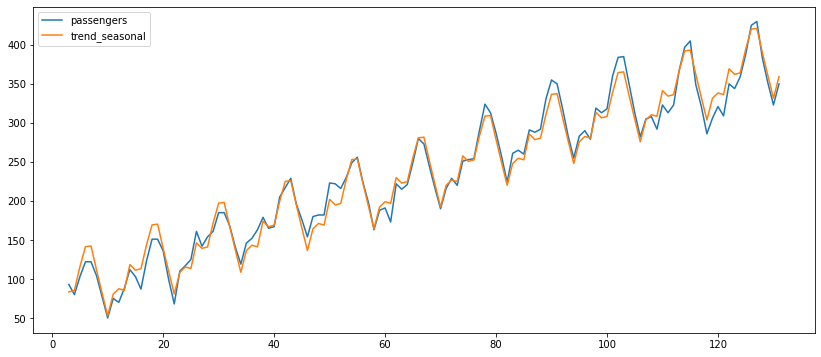

In [49]:
df[['passengers','trend_seasonal']].plot()

<AxesSubplot:>

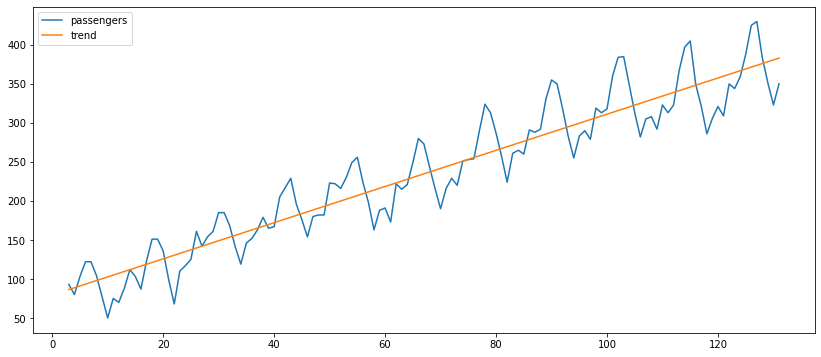

In [38]:
df[['passengers','trend']].plot()